# try to mitigate PSFs

attempt to use the fit_saturated_stars code from jw02731 development to fit stars and remove their PSFs

## Preamble: load things

In [1]:
import sys
sys.path.append('../reduction')
from saturated_star_finding import *

/blue/adamginsburg/adamginsburg/jwst/brick/notebooks/../reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [6]:
import warnings

In [7]:
import regions

In [8]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [10]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100

In [11]:
import glob
from astropy.io import fits

In [12]:
ls ../F466N/pipeline/*-merge*fits

../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d_satstar_catalog.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d_unsatstar.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d_reprj_f410.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_segm.fits


In [13]:
from astropy.io import fits

## Load & inspect data

In [14]:
fh = fits.open('../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d.fits')

In [15]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [16]:
np.any(bad)

True

In [17]:
data = fh['SCI'].data
data[bad] = 0

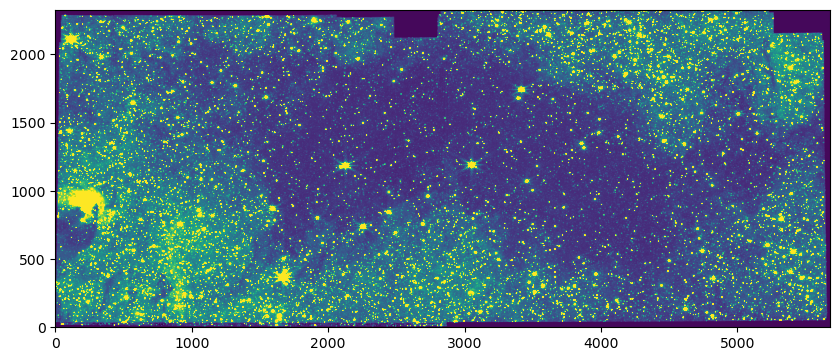

In [18]:
pl.imshow(data, vmin=-1, vmax=50, origin='lower')

54

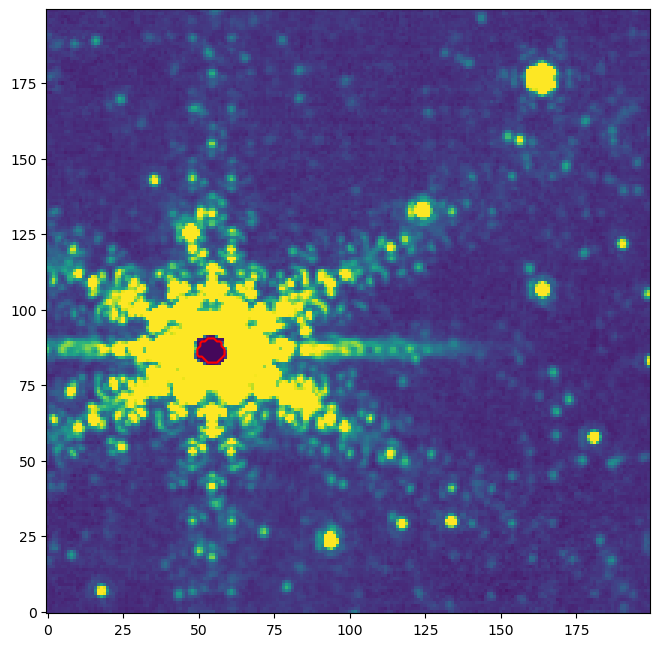

In [19]:
slc = slice(1100, 1300), slice(3000, 3200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

25

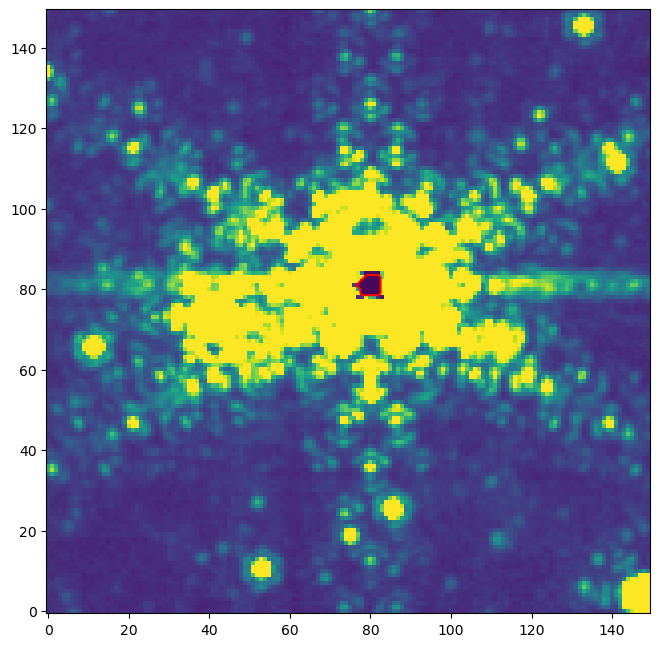

In [20]:
slc = slice(1100, 1250), slice(2050, 2200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

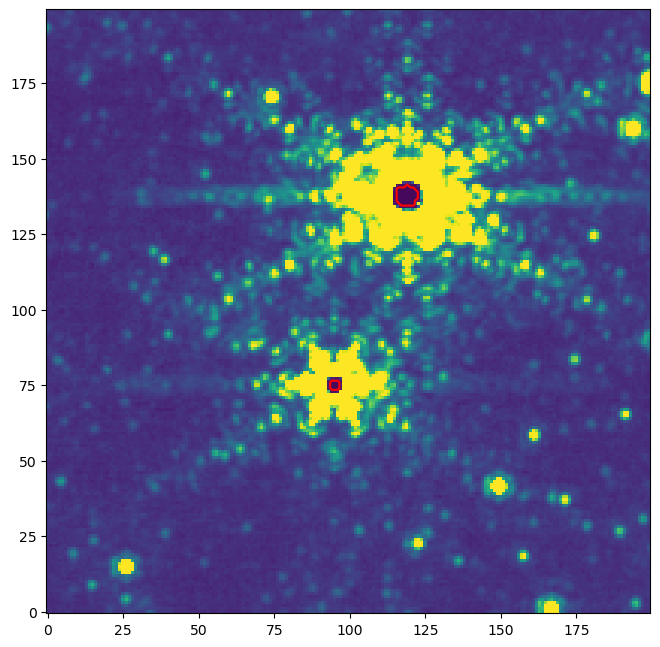

In [21]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 100) and min_flux=500, number of is_star=99, sizes=112, centerofmass_finite=112, coms_inbounds=112, total=99 candidates


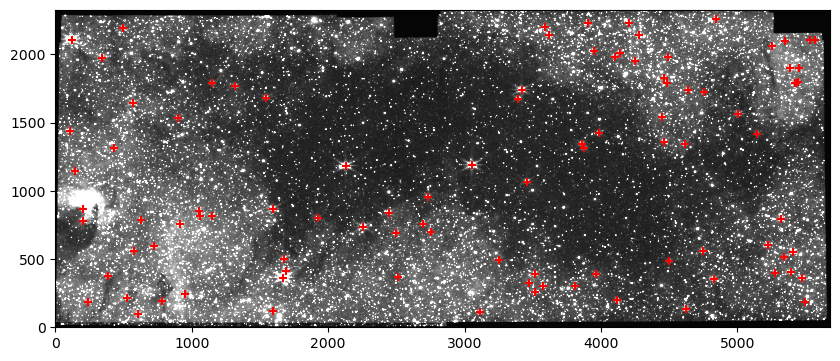

In [22]:
satstar_cat = finder_maker(min_sep_from_edge=50)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [23]:
header = fh[0].header
header.update(fh[1].header)
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), header)

Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: Loading grid from psf_fn=./nircam_F466N_samp2_nspsf16_npix512_nrcb5.fits [saturated_star_finding]
Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_

Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (50, 100) and min_flux=750, number of is_star=3, sizes=3, centerofmass_finite=112, coms_inbounds=112, total=3 candidates
Before trying with progressbar: resid shape=(2328, 5681), mask shape=(2328, 5681)
Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (50, 100) and min_flux=750, number of is_star=3, sizes=3, centerofmass_finite=112, coms_inbounds=112, total=3 candidates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.73s/it]


       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit          flux_unc            x_0_unc              y_0_unc                     skycoord_fit             
                                                                                                                                                                                                          deg,deg                
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ----------------- ------------------ -------------------- -------------------- --------------------------------------
1672.3417721518988 363.34177215189874  920667.5621203217   1        1 1672.5159673157607 363.15801755282683 6939965.321650894 28737.703910665867 0.005626799793248592 0.006180539149700383  266.5199298222817,-28.733397642532925
3054.0925925925926 1186.4259259259259 441115.18904128775   2        2  3054.575280444512 1186.59

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.22s/it]


       x_0               y_0               flux_0       id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc              y_0_unc                     skycoord_fit             
                                                                                                                                                                                                         deg,deg                
----------------- ------------------ ----------------- --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- -------------------- --------------------------------------
          2129.96            1180.92 482089.8550101172   1        1 2130.3908755169705 1180.7713579383935 2472803.1110610184 30615.938258144703 0.012921582521849537 0.012584499492238171  266.53610558453704,-28.72516785838226
3418.846153846154 1737.6923076923076 299622.1546764254   2        2  3419.343217880852 1737.50185598

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:02<00:00,  4.69s/it]


       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc              y_0_unc                     skycoord_fit             
                                                                                                                                                                                                           deg,deg                
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- -------------------- --------------------------------------
            3116.5              110.5  227588.4036881694   1        1 3116.6120869351525 110.31112470660821  399434.6753048361 12099.922871390714  0.04649812244701246  0.04927121335940601   266.5144485832695,-28.70819585527714
            4622.5 133.22222222222223 194132.54550943375   2        2  4622.111557251009 133

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:26<00:00,  3.31s/it]


       x_0               y_0               flux_0        id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc               y_0_unc                     skycoord_fit             
                                                                                                                                                                                                           deg,deg                
----------------- ------------------ ------------------ --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- --------------------- --------------------------------------
            242.0              186.5 128097.43105038573   1        1 241.95738166236882 186.66408874785535  281198.4613230768   2088.22523233712 0.011295377471556598  0.012202881241278383  266.51683999226645,-28.75847631328244
            783.5              194.0 114425.03695443372   2        2   783.648754444019 194.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [02:30<00:00,  2.90s/it]


       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc              y_0_unc                     skycoord_fit             
                                                                                                                                                                                                           deg,deg                
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- -------------------- --------------------------------------
             608.0               99.5   88035.9130972873   1        1  607.6485285327467    96.912733413182 23450.086431931017 1481.6608929430033  0.08717861699964051    0.103765824123464 266.51493818645343,-28.752101217196802
            1596.5              116.5  84492.26228151203   2        2  1596.473748690144 116

In [24]:
satstar_table[:3]

<QTable length=3>
       x_0                y_0               flux_0         id  group_id       x_fit              y_fit             flux_fit          flux_unc            x_0_unc              y_0_unc                     skycoord_fit             
                                                                                                                                                                                                            deg,deg                
     float64            float64            float64       int64  int64        float64            float64            float64           float64             float64              float64                       SkyCoord               
------------------ ------------------ ------------------ ----- -------- ------------------ ------------------ ----------------- ------------------ -------------------- -------------------- --------------------------------------
1672.3417721518988 363.34177215189874  920667.5621203217     1        1 1672.5159673157607 363.15801755282683 6939965.321650894 28737.703910665867 0.005626799793248592 0.006180539149700383  266.5199298222817,-28.733397642532925
3054.0925925925926 1186.4259259259259 441115.18904128775     2        2  3054.575280444512 1186.5927474625155 3266605.373876641  9447.862326578594 0.003952746566626915  0.00420736747499905 266.53593964065203,-28.708994972442813
120.01010101010101  2107.090909090909  664275.6873329213     3        3 119.51871714716864  2107.307109726284 5031288.301538509  30270.70795925081 0.008458055758859358 0.009109461867771078  266.55521347949355,-28.76010459743011

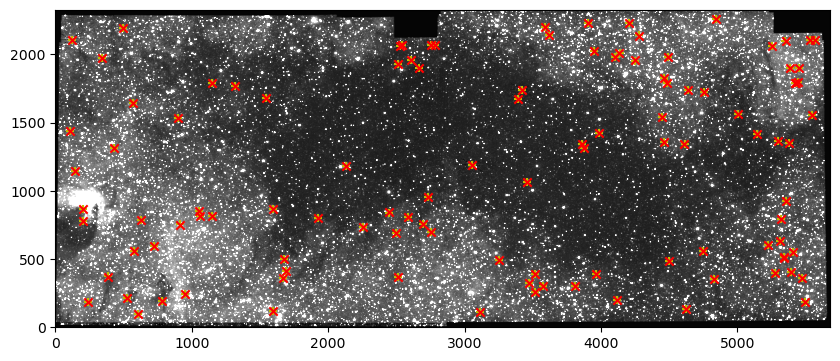

In [25]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')

(0.0, 200.0, 0.0, 200.0)

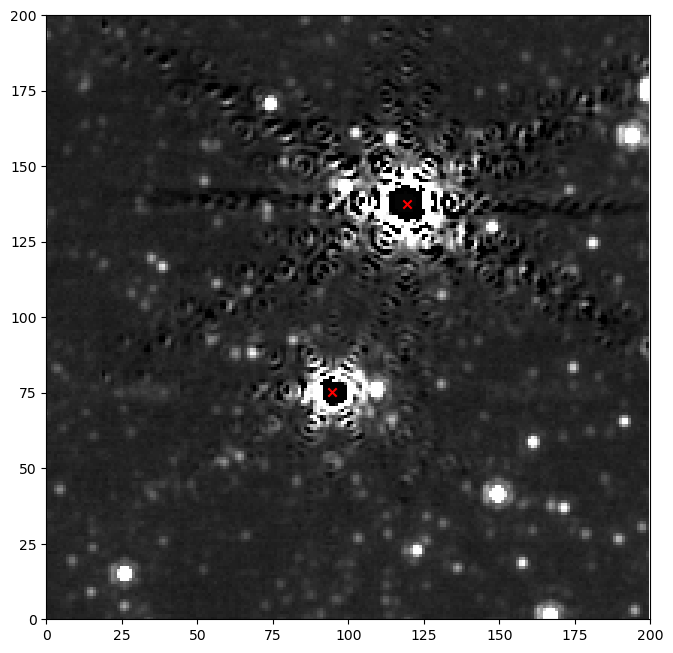

In [26]:
pl.imshow(satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

(0.0, 200.0, 0.0, 200.0)

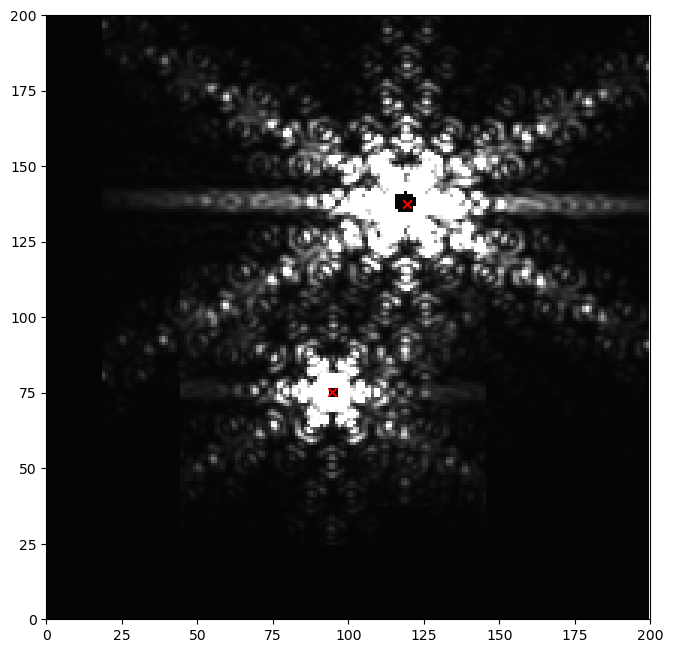

In [27]:
pl.imshow(data[1600:1800, 3300:3500] - satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

## Repeat for more difficult case: F410M

In [28]:
fh = fits.open('../F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged_i2d.fits')

In [29]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [30]:
np.any(bad)

True

In [31]:
data = fh['SCI'].data
data[bad] = 0

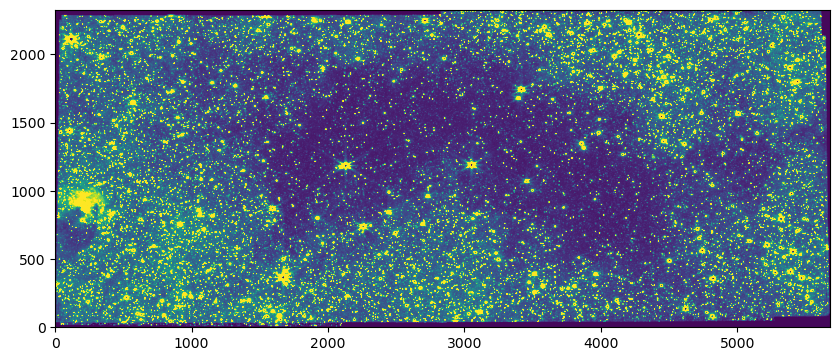

In [32]:
pl.imshow(data, vmin=-1, vmax=50, origin='lower')

325

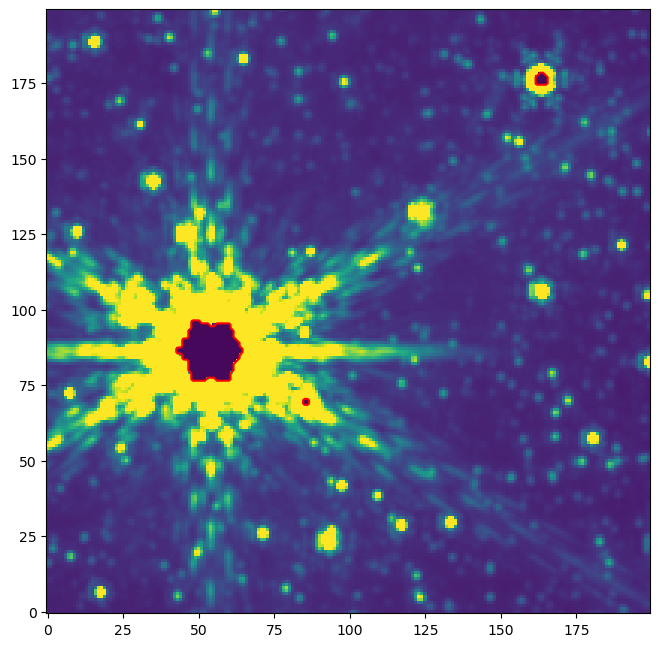

In [33]:
slc = slice(1100, 1300), slice(3000, 3200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

331

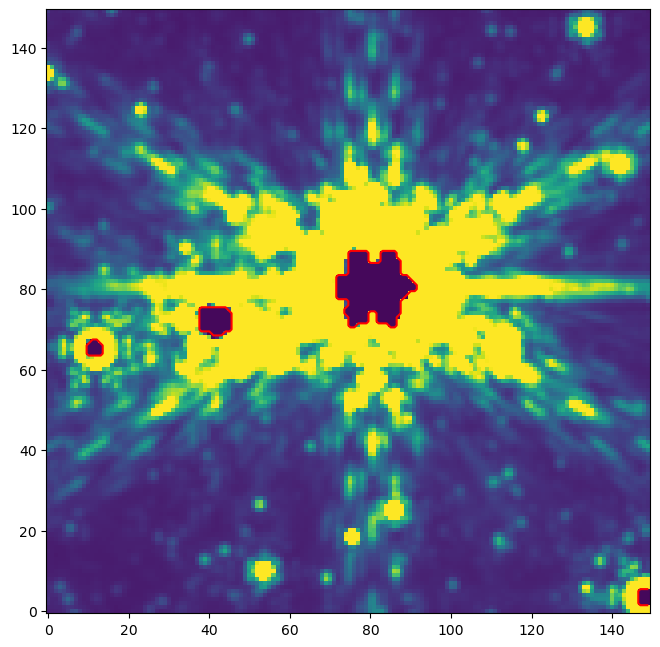

In [34]:
slc = slice(1100, 1250), slice(2050, 2200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

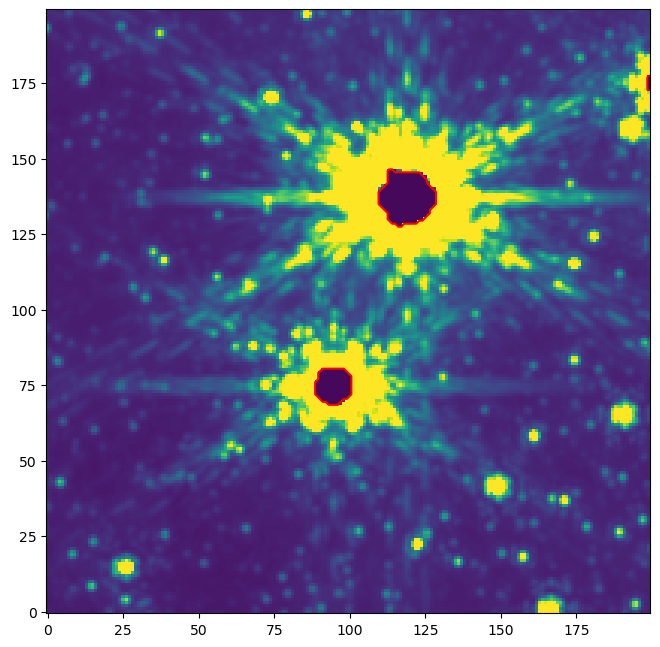

In [35]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

Reduced nsources from 3329 to 2017 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 100) and min_flux=500, number of is_star=1915, sizes=1942, centerofmass_finite=2017, coms_inbounds=2017, total=1915 candidates


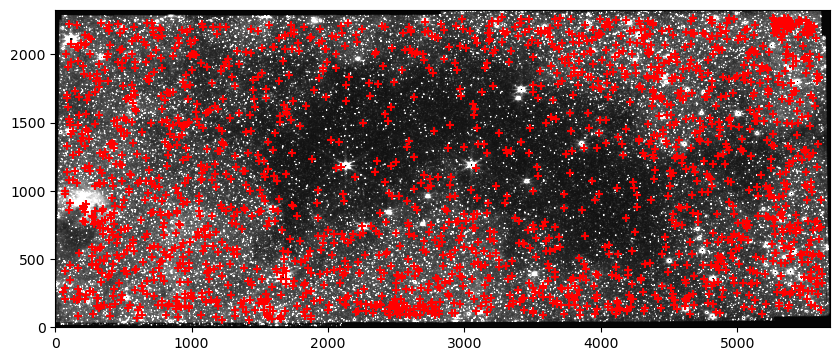

In [36]:
satstar_cat = finder_maker(min_sep_from_edge=50)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [37]:
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), fh[0].header)

AssertionError: 

In [ ]:
satstar_table[:3]

In [ ]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')

In [ ]:
pl.imshow(satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

In [ ]:
pl.imshow(data[1600:1800, 3300:3500] - satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

# Validate the starfinder (since it isn't working above...)

It is working well _now_, but this was to make the debug cycle faster by using smaller image cutouts

In [ ]:
#2510:2660,3105:3280
validation_slice = slice(1500,1950),slice(3200, 3650)

In [ ]:
pl.imshow(data[validation_slice], origin='lower')
pl.contour(data[validation_slice]==0, levels=[0.5], colors='r')

In [ ]:
saturated = data[validation_slice]==0
sources, nsources = label(saturated)
slices = find_objects(sources)

coms = center_of_mass(saturated, sources, np.arange(nsources)+1)
coms = np.array(coms)

sizes = sum_labels(saturated, sources, np.arange(nsources)+1)
msfe = 20
#sizes_ok = (sizes < max_size) & (sizes > min_size)
coms_finite = np.isfinite(coms).all(axis=1)
coms_inbounds = (
    (coms[:,1] > msfe) & (coms[:,0] > msfe) &
    (coms[:,1] < data.shape[1]-msfe) &
    (coms[:,0] < data.shape[0]-msfe)
        )
srcid=0
rindsize=3
slc = slices[0]
slc = tuple(slice(max(ss.start-rindsize, 0),
                      min(ss.stop+rindsize, shp)) for ss,shp in zip(slc, data.shape))

pl.imshow(data[validation_slice][slc])
is_star(data[validation_slice], sources, srcid+1, slices[0], min_flux=5000, rindsize=rindsize), slices, coms , sizes, nsources

In [ ]:
finder_maker(min_size=0, max_size=200)(data[validation_slice])

In [ ]:
finder_maker(min_size=0, max_size=500)(data[validation_slice], mask=ndimage.binary_dilation(data==0, iterations=1))

In [ ]:
hdr = fh[0].header.copy()
hdr.update(wcs.WCS(fh[0].header)[validation_slice].to_header())
ex_satstar_table, ex_satstar_resid = iteratively_remove_saturated_stars(data[validation_slice].copy(), hdr, verbose=True)

In [ ]:
pl.subplot(1,3,1)
pl.imshow(data[validation_slice], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
axs = (100,300,100,300)
pl.title("Data")
pl.axis(axs)

pl.subplot(1,3,2)
pl.imshow(ex_satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
pl.title("Residual")
pl.axis(axs)

pl.subplot(1,3,3)
pl.imshow(data[validation_slice] - ex_satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
pl.title("Model")
pl.axis(axs)

# Test on F405N

In [38]:
import saturated_star_finding
import imp
imp.reload(saturated_star_finding)
from saturated_star_finding import *

In [39]:
fh = fits.open('../F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')

In [40]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [41]:
np.any(bad)

True

In [42]:
# examine a specific chunk
def bad_star_zoom(cutout, fh=fh):
    pl.figure(figsize=(14,6))
    for ii, ext in enumerate(fh[1:8]):
        pl.subplot(2,4,ii+1)
        im = ext.data
        if ext.header['EXTNAME'] == 'CON':
            im_ = pl.imshow(np.log2(im[cutout]), origin='lower', cmap='jet')
        else:
            im_ = pl.imshow(im[cutout],
                      norm=simple_norm(im[cutout], stretch='asinh'),
                      origin='lower')
            pl.contour(im[cutout]==0, levels=[0.5], colors=['w'])
        pl.colorbar(mappable=im_)
        pl.title(ext.header['EXTNAME'])
    ext = fh[3]
    ext_remap = ext.data.copy()[cutout]
    for ii,val in enumerate(np.unique(ext.data)):
        msk = ext.data[cutout] == val
        if msk.any():
            ext_remap[msk] = f'{val:032b}'.count('1')
            #print(f'{ii}: {val:032b}')
    pl.subplot(2,4,8)
    pl.imshow(ext_remap, origin='lower')
    pl.title("CON - bitsum")
    pl.colorbar()

## this star doesn't have any zeros but is clearly saturated

we can identify it by its variance being zero but that's the only way?

/scratch/local/49957816/ipykernel_46569/2707514664.py:13: UserWarning: No contour levels were found within the data range.
  pl.contour(im[cutout]==0, levels=[0.5], colors=['w'])


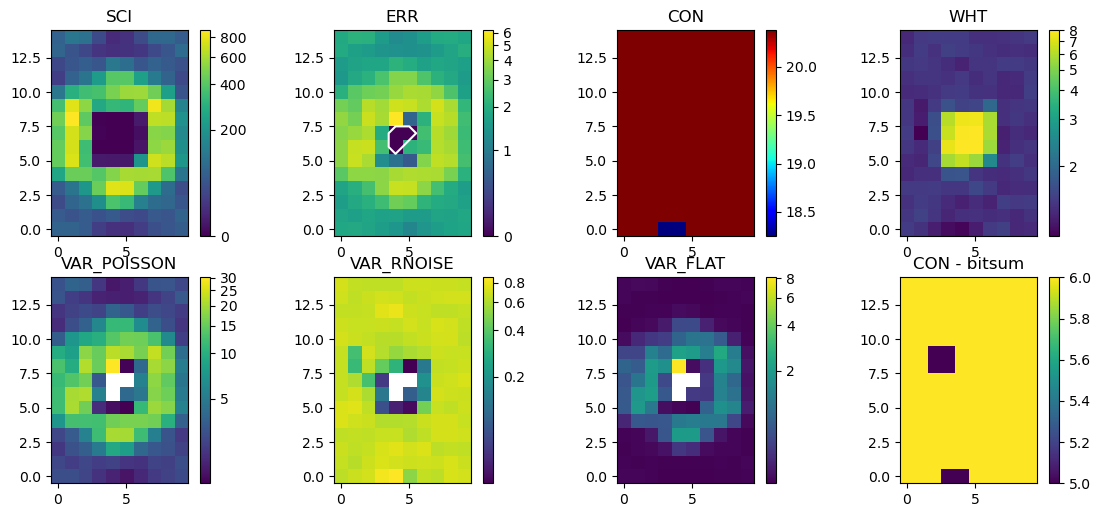

In [43]:
bad_star_zoom((slice(1040, 1055), slice(327, 337)), fh)

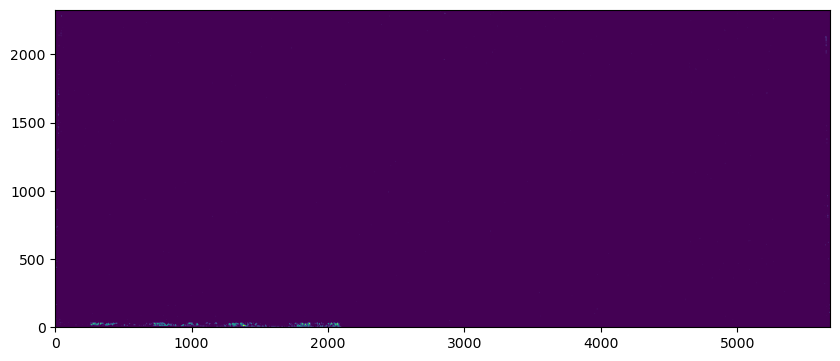

In [44]:
pl.imshow(data<0)

Reduced nsources from 3329 to 2017 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 1000) and min_flux=500, number of is_star=2014, sizes=2017, centerofmass_finite=2017, coms_inbounds=2017, total=2014 candidates


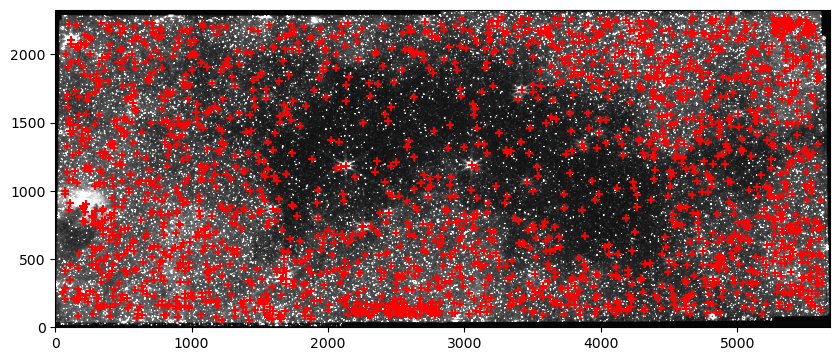

In [45]:
satstar_cat = finder_maker(min_sep_from_edge=50, max_size=1000, rindsize=4)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [46]:
finder_maker(min_sep_from_edge=50, max_size=1000, min_size=25, rindsize=4)(data[1600:1800, 3300:3500])

Reduced nsources from 3 to 3 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (25, 1000) and min_flux=500, number of is_star=2, sizes=2, centerofmass_finite=3, coms_inbounds=2, total=2 candidates


<Table length=2>
  id      xcentroid         ycentroid    
int64      float64           float64     
----- ----------------- -----------------
    1 94.56198347107438 74.80165289256199
    2 118.8423076923077 137.0423076923077

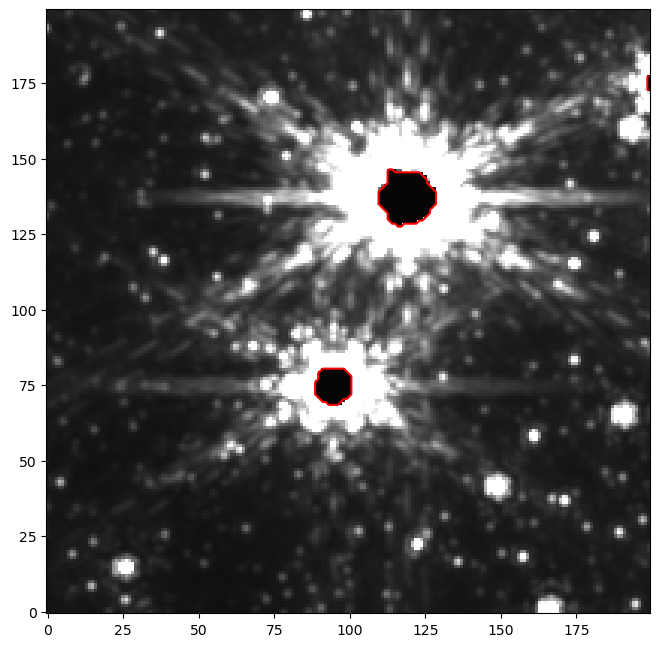

In [47]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

In [48]:
header = fh[0].header
header.update(fh[1].header)
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), header)

Set OBSGEO-B to   -20.697594 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526831525.846 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: Loading grid from psf_fn=./nircam_F405N_samp2_nspsf16_npix512_nrca5.fits [saturated_star_finding]
Reduced nsources from 3329 to 2017 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (100, 500) and min_flux=1000, number of i

 12%|███████████████████████▉                                                                                                                                                                             | 9/74 [01:38<11:54, 10.99s/it]


KeyboardInterrupt: 

In [ ]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')

# Inspect a saturated start in F410 that's not turning up saturated

In [53]:
fh410 = fits.open('../F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged_i2d.fits')

In [54]:
bad = (fh410['CON'].data == 0) | (fh410['WHT'].data == 0) | (fh410['ERR'].data == 0)

In [55]:
np.any(bad)

True

/scratch/local/49957816/ipykernel_46569/2707514664.py:13: UserWarning: No contour levels were found within the data range.
  pl.contour(im[cutout]==0, levels=[0.5], colors=['w'])


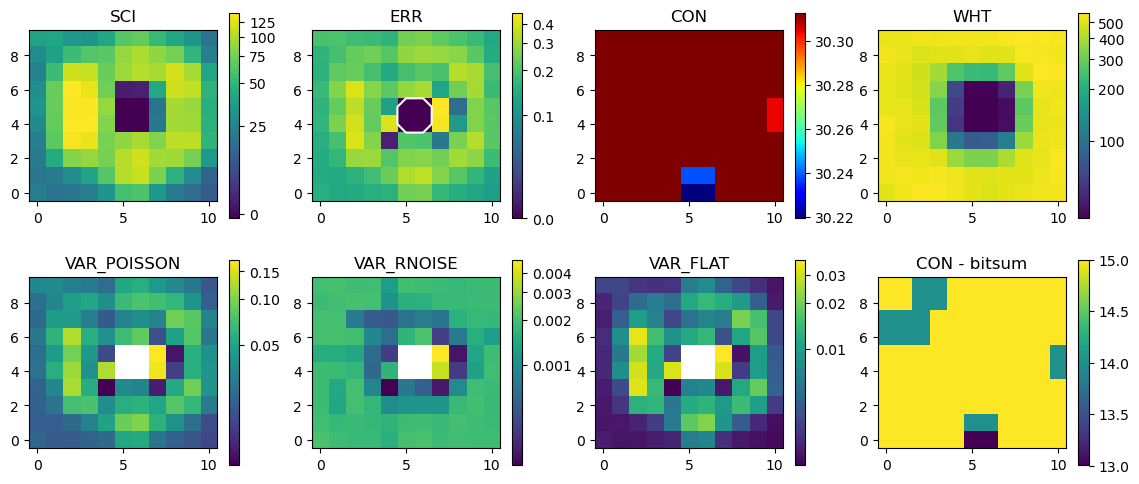

In [57]:
starslc = (slice(1390, 1400), slice(868, 879))
bad_star_zoom(starslc, fh410)

In [62]:
hdr = fh410[0].header.copy()
hdr.update(wcs.WCS(fh410[1].header)[starslc].to_header())
iteratively_remove_saturated_stars(fh410[1].data[starslc], header=hdr)

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: Loading grid from psf_fn=./nircam_F410M_samp2_nspsf16_npix512_nrca5.fits [saturated_star_finding]


ValueError: no values provided to stack.